In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
from collections import defaultdict, Counter
from file_storage import FileStorage
from heapq import heappush, heappop


from bs4 import BeautifulSoup
from urllib.parse import urljoin
from urllib.parse import urldefrag
import pickle
import tqdm

In [4]:
file_storage = FileStorage('../filtered_storage')
len(file_storage)

157154

In [5]:
def extract_links_from_html(url, html):
    parser = BeautifulSoup(html)
    return [
        urldefrag(urljoin(url, link.get('href'))).url
        for link in parser.findAll('a')
    ]


def build_neighbors(storage):
    result = {}
    for url, page in tqdm.tqdm(storage.items(), total=len(storage)):
        result[url] = [
            link for link in extract_links_from_html(url, page)
            if link in storage
        ]
    return result


def normilize_pagerank(pagerank, normalization_func=max):
    normalization = normalization_func(pagerank.values())
    return {url: rank / normalization for url, rank in pagerank.items()}


def calc_diff(rank_a, rank_b):
    return sum(
        (value_a - rank_b[key]) ** 2
        for key, value_a in rank_a.items()
    ) / len(rank_a)


def calc_pagerank(neighbors, iterations=20, delta=0.1, prev_pagerank=None, min_diff=1e-20):
    if prev_pagerank is None:
        prev_pagerank = defaultdict(lambda: 1 / len(neighbors))

    for ind in range(iterations):
        print('{} iteration, India rank: {}'.format(
            ind, prev_pagerank['https://simple.wikipedia.org/wiki/India']
        ))
        mean_pagerank = sum(prev_pagerank.values()) / len(prev_pagerank)
        pagerank = defaultdict(lambda: mean_pagerank * delta)
        for url in neighbors.keys():
            curr_neighbor_list = neighbors[url]
            for neighbor_url in curr_neighbor_list:
                pagerank[neighbor_url] += prev_pagerank[url] / len(curr_neighbor_list) * (1 - delta)
        pagerank = normilize_pagerank(pagerank)
        diff = calc_diff(pagerank, prev_pagerank)
        print('diff: ' + str(diff))
        if diff < min_diff:
            break
        prev_pagerank = pagerank
    return pagerank

In [6]:
neighbors = build_neighbors(file_storage)

100%|██████████| 157154/157154 [1:04:57<00:00, 40.32it/s]


In [7]:
with open('neighbors.pkl', 'wb') as f_out:
    pickle.dump(neighbors, f_out)

In [17]:
with open('neighbors.pkl', 'rb') as nei_file:
    neighbors = pickle.load(nei_file, encoding='utf-8')

In [8]:
neighbors_sets = {url: set(neighbor_list) for url, neighbor_list in neighbors.items()}

In [9]:
pagerank = calc_pagerank(neighbors, iterations=50)

0 iteration, India rank: 6.363185155961668e-06
diff: 6.498830639862381e-06
1 iteration, India rank: 0.011153841633878397
diff: 9.695499152897899e-08
2 iteration, India rank: 0.016433137199733355
diff: 1.7837428660129294e-08
3 iteration, India rank: 0.01967546741884423
diff: 4.929598694172049e-09
4 iteration, India rank: 0.020752173792810955
diff: 1.723636568875436e-09
5 iteration, India rank: 0.021038478362333777
diff: 6.796160961582491e-10
6 iteration, India rank: 0.0210928643021524
diff: 2.910212610972103e-10
7 iteration, India rank: 0.021083982027049454
diff: 1.348633558393078e-10
8 iteration, India rank: 0.021062598526175078
diff: 6.566972927109686e-11
9 iteration, India rank: 0.021042581726013608
diff: 3.391479836856501e-11
10 iteration, India rank: 0.021026925060522537
diff: 1.8059773454037743e-11
11 iteration, India rank: 0.021015229917794795
diff: 1.0033340249107487e-11
12 iteration, India rank: 0.02100658578423475
diff: 5.677615890879299e-12
13 iteration, India rank: 0.0210000

In [12]:
def dump_pagerank(pagerank, path='pagerank_results.txt'):
    with open(path, 'w') as pagerank_file:
        for url, rank in pagerank.items():
            pagerank_file.write("{:>7.6} {}\n".format(rank, url))


def load_pagerank(path='pagerank_results.txt'):
    with open(path) as pagerank_file:
        pagerank = {}
        for line in pagerank_file:
            rank, url = line.strip().split()
            pagerank[url] = float(rank)
        return pagerank

In [13]:
dump_pagerank(pagerank)

In [14]:
pagerank = load_pagerank()

In [48]:
incoming_edges = defaultdict(set)
for url, neighbor_iterable in neighbors.items():
    for neighbor in neighbor_iterable:
        incoming_edges[neighbor].add(url)

In [62]:
len(super_cheat)

144743

In [104]:
def cheat_crawling(pagerank, neighbors, seed='https://simple.wikipedia.org/wiki/Main_Page'):
    priority_queue = []
    seen = {seed}
    pagerank_order = []
    heappush(priority_queue, (-pagerank[seed], seed))
    
    while priority_queue:
        rank, url = heappop(priority_queue)
        pagerank_order.append(-rank)
        for neighbor in neighbors[url]:
            if neighbor not in seen:
                heappush(priority_queue, (-pagerank[neighbor], neighbor))
                seen.add(neighbor)
    return pagerank_order

In [105]:
cheat = np.cumsum(cheat_crawling(pagerank, neighbors_sets))

In [51]:
def BFS_crawling(pagerank, neighbors, seed='https://simple.wikipedia.org/wiki/Main_Page'):
    queue = [seed]
    seen = {seed}
    pagerank_order = []
    
    while queue:
        url = queue.pop(0)
        pagerank_order.append(pagerank[url])
        for neighbor in neighbors[url]:
            if neighbor not in seen:
                queue.append(neighbor)
                seen.add(neighbor)
    return pagerank_order, seen

In [77]:
bfs_pagerank_order, seen = BFS_crawling(pagerank, neighbors_sets)

In [64]:
Counter([len(incoming_edges[url]) for url in (set(file_storage.keys()) - seen)]).items()

dict_items([(1, 12411), (2, 2583), (3, 393), (4, 95), (5, 61), (14, 1), (17, 16), (6, 24), (16, 18), (8, 6), (13, 3), (19, 1), (20, 2), (15, 1), (7, 2), (18, 4), (9, 2), (10, 1)])

In [69]:
diff = set(file_storage.keys()) - seen

In [76]:
for url in (set(file_storage.keys()) - seen):
    if len(incoming_edges[url]) > 18:
        print(url)
        print(incoming_edges[url])

https://simple.wikipedia.org/wiki/University_of_the_City_of_Manila
{'https://simple.wikipedia.org/wiki/PLM_College_of_Science', 'https://simple.wikipedia.org/wiki/University_of_the_City_of_Manila', 'https://simple.wikipedia.org/wiki/PLM_College_of_Accountancy_%26_Economics', 'https://simple.wikipedia.org/wiki/PLM_College_of_Management_%26_Entrepreneurship', 'https://simple.wikipedia.org/wiki/PLM_College_of_Law', 'https://simple.wikipedia.org/wiki/PLM_College_of_Tourism,_Hotel_and_Travel_Industry_Management', 'https://simple.wikipedia.org/wiki/PLM_College_of_Tourism,_Hotel_%26_Travel_Industry_Management', 'https://simple.wikipedia.org/wiki/Benjamin_Tayabas', 'https://simple.wikipedia.org/wiki/Adel_Tamano', 'https://simple.wikipedia.org/wiki/PLM_College_of_Human_Development', 'https://simple.wikipedia.org/wiki/Pamantasan_ng_Lungsod_ng_Maynila', 'https://simple.wikipedia.org/wiki/PLM_College_of_Liberal_Arts', 'https://simple.wikipedia.org/wiki/PLM_College_of_Medicine', 'https://simple.wik

In [ ]:
for url in diff:
    if any(nei not in diff for nei in incoming_edges[url]):
        print(url)
        print(incoming_edges[url])

In [78]:
bfs = np.cumsum(bfs_pagerank_order)

In [79]:
def random_crawling(pagerank, neighbors, seed='https://simple.wikipedia.org/wiki/Main_Page'):
    queue = [seed]
    seen = {seed}
    pagerank_order = []
    
    while queue:
        rnd_ind = np.random.randint(0, len(queue))
        url = queue.pop(rnd_ind)
        pagerank_order.append(pagerank[url])
        for neighbor in neighbors[url]:
            if neighbor not in seen:
                queue.append(neighbor)
                seen.add(neighbor)
    return pagerank_order, seen

In [80]:
random_pagerank_order, random_seen = random_crawling(pagerank, neighbors_sets)
random = np.cumsum(random_pagerank_order)

In [81]:
random_seen == seen

True

In [83]:
def priority_by_in_degree_crawling(pagerank, neighbors, seed='https://simple.wikipedia.org/wiki/Main_Page'):
    priority_queue = []
    seen = {seed}
    pagerank_order = []
    incoming_edges = defaultdict(set)
    heappush(priority_queue, (len(incoming_edges[seed]), seed))
    
    while priority_queue:
        rank, url = heappop(priority_queue)
        pagerank_order.append(pagerank[url])
        for neighbor in neighbors[url]:
            incoming_edges[neighbor].add(url)
            if neighbor not in seen:
                heappush(priority_queue, (len(incoming_edges[neighbor]), neighbor))
                seen.add(neighbor)
    return pagerank_order

In [98]:
super_cheat = np.cumsum(sorted((value for url, value in pagerank.items() if url in seen), reverse=True))

In [85]:
priority_by_in_degree = np.cumsum(priority_by_in_degree_crawling(pagerank, neighbors_sets))

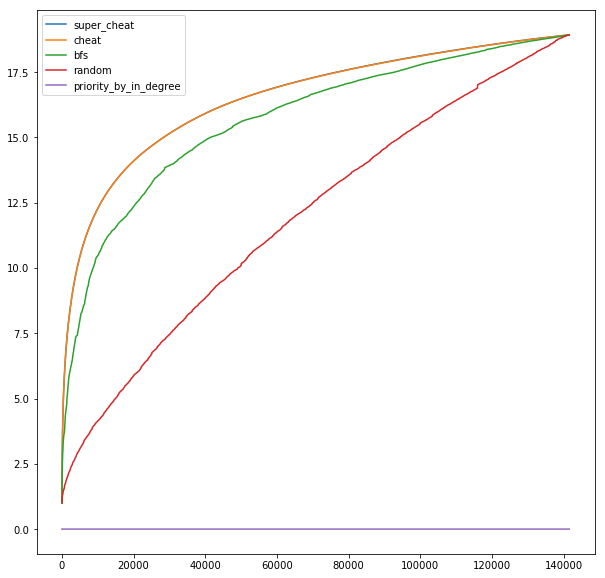

In [108]:
x = np.arange(len(cheat))
plt.figure(figsize=(10, 10))
plt.plot(x, super_cheat, label='super_cheat')
plt.plot(x, cheat, label='cheat')
plt.plot(x, bfs, label='bfs')
plt.plot(x, random, label='random')
plt.plot(x, priority_by_in_degree, label='priority_by_in_degree')
plt.legend()
plt.show()

In [112]:
cheat

array([ 1.        ,  1.0332813 ,  1.1556423 , ..., 18.92317288,
       18.92318528, 18.92319767])

In [113]:
super_cheat

array([ 1.        ,  1.122361  ,  1.1935141 , ..., 18.92317288,
       18.92318528, 18.92319767])